# Toy data
> Randomly-spaced points on a hyperbolic branch

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from src.toy_data import generate_points_on_branch


In [13]:
# Generate 2 sets of points, for classification:

root = np.array([1.0, 0.0, 0.0])
points = []
labels = []
for i in range(3):
    points.append(
        generate_points_on_branch(
            root=root,
            direction=np.random.rand(3),
            num_points=100,
            noise_std=0.1,
        )
    )
    labels += [i] * 100

data = np.vstack(points)
labels = np.array(labels)


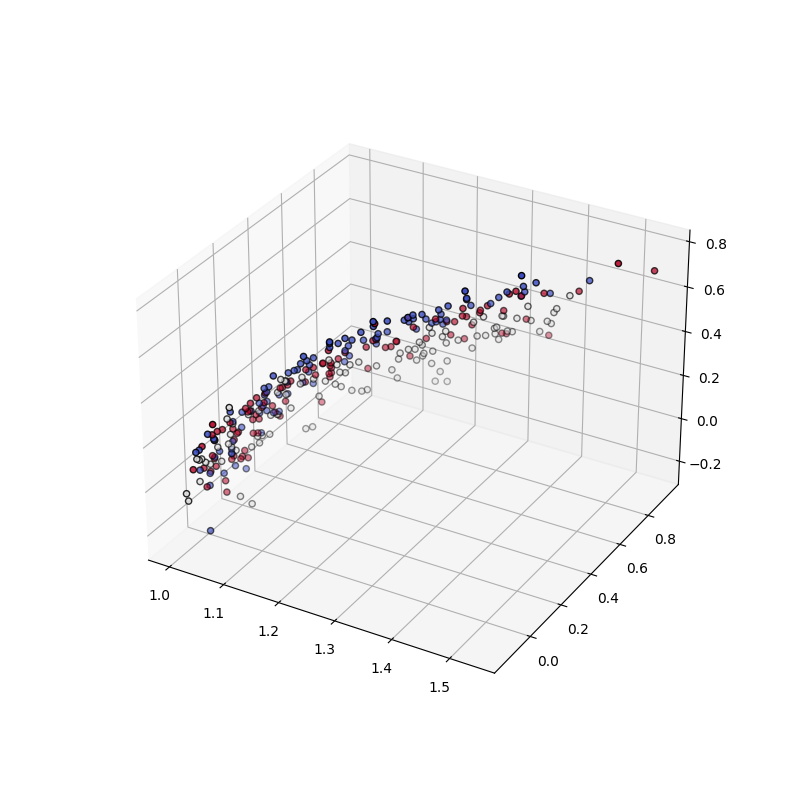

In [14]:
# Plot the points

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="coolwarm", edgecolor="k"
)
plt.show()


In [16]:
# Try to classify using hyperbolic and regular decision trees

from sklearn.tree import DecisionTreeClassifier
from src.tree import HyperbolicDecisionTreeClassifier  # , DecisionTree
from src.forest import HyperbolicRandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

# Hyperparameters
MIN_SAMPLES = 2
MAX_DEPTH = 10
args = dict(min_samples=MIN_SAMPLES, max_depth=MAX_DEPTH)

# Fit a regular decision tree
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier(**args)
hdt.fit(X_train, y_train)

# Control dt
hdt_control = HyperbolicDecisionTreeClassifier(hyperbolic=False, **args)
hdt_control.fit(X_train, y_train)

# Random forest
hrf = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=True, **args
)
hrf.fit(X_train, y_train)

hrf_control = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=False, **args
)
hrf_control.fit(X_train, y_train)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy (control): {accuracy_score(y_test, hdt_control.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy: {accuracy_score(y_test, hrf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy (control): {accuracy_score(y_test, hrf_control.predict(X_test)):.3f}",
    sep="\n",
)


Regular decision tree accuracy: 0.450
Hyperbolic decision tree accuracy: 0.350
Hyperbolic decision tree accuracy (control): 0.267
Hyperbolic random forest accuracy: 0.350
Hyperbolic random forest accuracy (control): 0.267


In [17]:
# Try it on americangut

import anndata
import numpy as np

adata = anndata.read_h5ad(
    "/home/phil/americangut/data/americangut_embeddings.h5ad"
)

neg_master = ["no", "false", "i do not have this condition", "never"]

pos_master = [
    "yes",
    "true",
    "diagnosed by a medical professional (doctor, physician assistant)",
    "self-diagnosed",
    "diagnosed by an alternative medicine practitioner",
    "rarely (less than once/week)",
    "rarely (a few times/month)",
    "occasionally (1-2 times/week)",
    "regularly (3-5 times/week)",
    "daily",
]

nan_master = ["nan", "not provided", "not sure", "not collected", "unspecified"]


def classify(
    column,
    pos_vals=pos_master,
    neg_vals=neg_master,
    nan_vals=nan_master,
    data=adata.X.toarray(),
    balance=False,
    seed=None,
):
    vals = adata.obs[column].str.lower()
    nan_vals = vals.isna() | vals.isin(nan_vals)
    pos_vals = vals.isin(pos_vals)
    neg_vals = vals.isin(neg_vals)
    assert not (pos_vals & neg_vals).any()
    try:
        assert (pos_vals | neg_vals | nan_vals).all()
    except AssertionError:
        print(column)
        print(vals[~(pos_vals | neg_vals | nan_vals)])

    X = np.array(data)[~nan_vals]
    y = np.array(pos_vals)[~nan_vals]

    n_pos = y.sum()
    n_neg = (~y).sum()

    if balance:
        if seed is not None:
            np.random.seed(seed)
        # Balance the classes
        if n_pos > n_neg:
            drop = np.random.choice(
                np.where(y)[0], n_pos - n_neg, replace=False
            )
        elif n_neg > n_pos:
            drop = np.random.choice(
                np.where(~y)[0], n_neg - n_pos, replace=False
            )
        X = np.delete(X, drop, axis=0)
        y = np.delete(y, drop, axis=0)

    return X, y


In [18]:
X_ibd, y_ibd = classify("ibd", balance=True, seed=42)


In [19]:
# Compare scores for different classifiers

X_train, X_test, y_train, y_test = train_test_split(
    X_ibd, y_ibd, test_size=0.2, random_state=42
)

# Hyperparameters
MIN_SAMPLES = 2
MAX_DEPTH = 10
args = dict(min_samples=MIN_SAMPLES, max_depth=MAX_DEPTH)

# Fit a regular decision tree
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier(**args)
hdt.fit(X_train, y_train)

# Control dt
hdt_control = HyperbolicDecisionTreeClassifier(hyperbolic=False, **args)
hdt_control.fit(X_train, y_train)

# Random forest
hrf = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=True, **args
)
hrf.fit(X_train, y_train)

hrf_control = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=False, **args
)
hrf_control.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=1000, max_depth=4)
rf.fit(X_train, y_train)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy (control): {accuracy_score(y_test, hdt_control.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy: {accuracy_score(y_test, hrf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy (control): {accuracy_score(y_test, hrf_control.predict(X_test)):.3f}",
    f"Random forest accuracy: {accuracy_score(y_test, rf.predict(X_test)):.3f}",
    sep="\n",
)
